Calendar: (1969, 14)
Prices: (6841121, 4)
Sales: (30490, 1919)


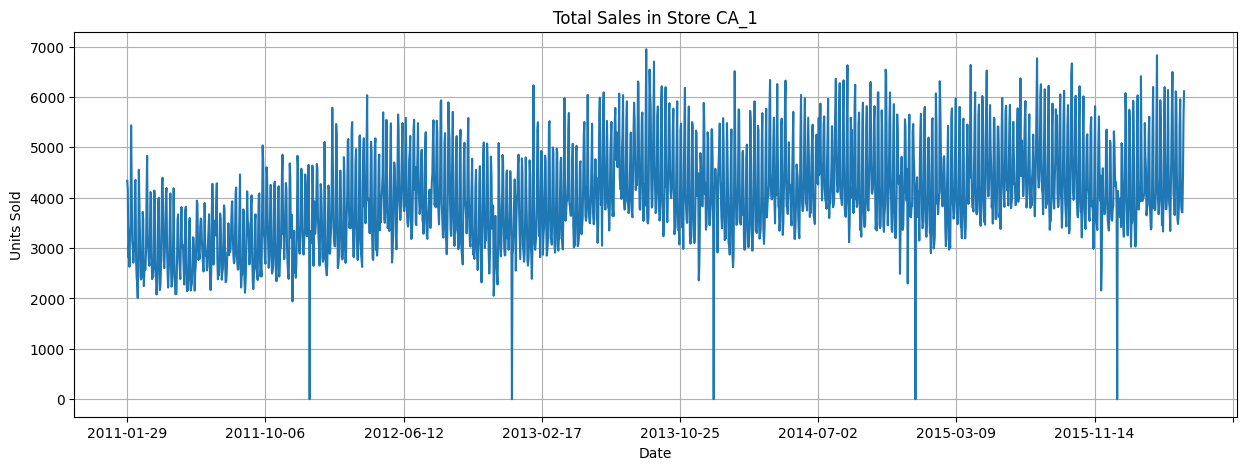

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

BASE = "/kaggle/input/m5-forecast-ds/"

# Load files
calendar   = pd.read_csv(BASE + "calendar.csv")
sell_prices = pd.read_csv(BASE + "sell_prices.csv")
sales_val   = pd.read_csv(BASE + "sales_train_validation.csv")

print("Calendar:", calendar.shape)
print("Prices:", sell_prices.shape)
print("Sales:", sales_val.shape)

# Example: plot total sales for CA_1
sales_ca1 = sales_val[sales_val["store_id"] == "CA_1"]

# Melt into long format for CA_1 only
sales_long = sales_ca1.melt(
    id_vars=["id","item_id","dept_id","cat_id","store_id","state_id"],
    var_name="d",
    value_name="sales"
).merge(calendar, on="d", how="left")

# Aggregate daily sales
daily_sales = sales_long.groupby("date")["sales"].sum()

plt.figure(figsize=(15,5))
daily_sales.plot()
plt.title("Total Sales in Store CA_1")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.show()


07:31:26 - cmdstanpy - INFO - Chain [1] start processing
07:31:26 - cmdstanpy - INFO - Chain [1] done processing


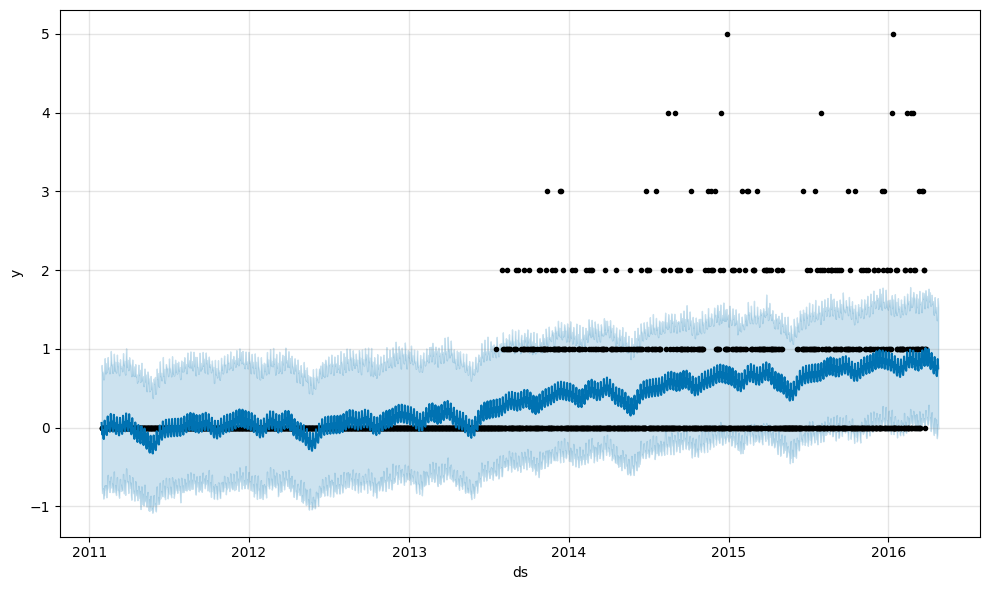

In [2]:
from prophet import Prophet

# Pick one item
sample_item = sales_long[sales_long["item_id"] == "HOBBIES_1_001"]

df_prophet = sample_item.groupby("date", as_index=False)["sales"].sum()
df_prophet = df_prophet.rename(columns={"date":"ds", "sales":"y"})

# Train-test split (last 28 days for validation)
train = df_prophet.iloc[:-28]
valid = df_prophet.iloc[-28:]

model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(train)

future = model.make_future_dataframe(periods=28)
forecast = model.predict(future)

fig = model.plot(forecast)


In [ ]:
# --- Step 3: Reshape sales data + Feature Engineering ---

# Melt wide format into long format
sales_long = sales_val.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="d",
    value_name="sales"
)

# Merge with calendar + sell_prices
df = sales_long.merge(calendar, on="d", how="left") \
               .merge(sell_prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")

# Pick a manageable subset (top 200 items from CA_1)
store_items = df[df["store_id"] == "CA_1"]["id"].unique()
print("Items in CA_1:", len(store_items), " | Using top 200 items")
store_items = store_items[:200]
df = df[df["id"].isin(store_items)]

# Add lag and rolling features
def add_lags(group):
    group = group.copy()
    for lag in [7, 14, 28]:
        group[f"lag_{lag}"] = group["sales"].shift(lag)
    for win in [7, 28]:
        group[f"rmean_{win}"] = group["sales"].shift(1).rolling(win).mean()
    return group

ml_df = df.groupby("id", group_keys=False).apply(add_lags).reset_index(drop=True)

print("ml_df shape:", ml_df.shape)
print(ml_df.head())


In [20]:
def add_lags(df):
    for lag in [7, 14, 28]:   # added lag_14 here ✅
        df[f"lag_{lag}"] = df["sales"].shift(lag)
    for win in [7, 28]:
        df[f"rmean_{win}"] = df["sales"].shift(1).rolling(win).mean()
    return df

# Apply per item
ml_df = df.groupby("id", group_keys=False, include_groups=False).apply(add_lags).reset_index(drop=True)

TypeError: DataFrame.groupby() got an unexpected keyword argument 'include_groups'